Comparing current predictor with previous methods

In [1]:
import xarray as xr
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

In [2]:
dataDIR = 'short'
DS = xr.open_dataset(dataDIR)

In [3]:
#Temperature:
T = (DS.T.values + DS.T0) * ((DS.P.values + DS.PB.values)/DS.P0)**(DS.R_D/DS.CP)

In [4]:
T.shape #days, height, latitude, longtitude

(240, 52, 36, 72)

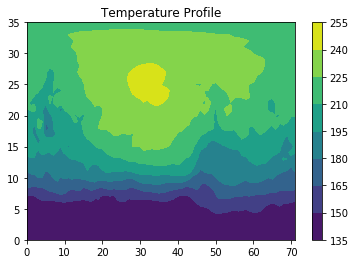

In [5]:
example_data = T[50,5,:, :]
plt.contourf(example_data)
plt.colorbar()
plt.title("Temperature Profile")
plt.show()

In [6]:
albedo = DS.ALBEDO.values

In [7]:
albedo.shape #days, latitude, longtitude

(240, 36, 72)

In [8]:
st = DS.TSK.values

In [9]:
st.shape

(240, 36, 72)

In [10]:
d_c = DS.TAU_OD.values

In [11]:
d_c.shape 

(240, 52, 36, 72)

In [12]:
tsf = DS.TOASW.values #top solar flux

In [13]:
tsf.shape

(240, 36, 72)

In [14]:
albedo = DS.ALBEDO.values

In [15]:
bsf = DS.GSW.values #bottom solar flux, ouput

In [16]:
bsf2 = bsf/(1-albedo)

In [17]:
bsf.shape

(240, 36, 72)

Let's combine the data together for ten time samples, with full latitude and longitude:

In [18]:
e_t = [] #equator input and output
#input:
for k in range(10): #10 days
    for i in range(36):
        for j in range(72):
            input_array = list(T[k,:,i,j]) #start with temp profile
            input_array+=list(d_c[k,:,i,j]) #add dust profile
            input_array.append(st[k,i,j])#add surface temp
            input_array.append(tsf[k,i,j]) #add top solar flux, without the albedo factor
            input_array.append(bsf2[k,i,j])            
            e_t.append(input_array) #appends input to input array

In [19]:
e_t = np.array(e_t)
e_t.shape

(25920, 107)

In [20]:
e_d = pd.DataFrame(e_t) 

Split up the data:

In [21]:
e_d = e_d[e_d.iloc[:,105] != 0] #remove 0 flux, could later use a simple classifier to determine which data has 0 bottom flux...
e_reml = e_d[e_d.iloc[:,105] > 20] #large flux data
e_rems = e_d[e_d.iloc[:,105] < 20] #small flux data

Train two linear regressors, one for the large flux data and the other for small flux data:

In [22]:
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression

train_set, test_set = train_test_split(e_reml, test_size=0.2, random_state=42)

train_in = train_set.iloc[:,:106] #training input
train_out = train_set.iloc[:,106] #training output
test_in = test_set.iloc[:,:106] #testing input 
test_out = test_set.iloc[:,106] #testing output

w = 1/train_out**2
lrl = LinearRegression() #linear regression for large flux data
lrl.fit(train_in,train_out, sample_weight=w)



LinearRegression(copy_X=True, fit_intercept=True, n_jobs=None, normalize=False)

In [23]:
train_set, test_set = train_test_split(e_rems, test_size=0.2, random_state=42)

train_in = train_set.iloc[:,:106] #training input
train_out = train_set.iloc[:,106] #training output
test_in = test_set.iloc[:,:106] #testing input
test_out = test_set.iloc[:,106] #testing output

w = 1/train_out**2
lrs = LinearRegression() #linear regression for small flux data
lrs.fit(train_in,train_out, sample_weight=w)


LinearRegression(copy_X=True, fit_intercept=True, n_jobs=None, normalize=False)

A custom predictor which can handle all the data:

In [24]:
def clp(in_data): #custom linear predictor
    in_data = np.array(in_data)
    out_data = []
    for instance in in_data:
        if instance[105] > 20:
            out_data.append(float(lrl.predict(instance[:106].reshape(1,-1)))) #uses large flux predictor 
        else:
            out_data.append(float(lrs.predict(instance[:106].reshape(1,-1)))) #uses small flux predictor
    return np.array(out_data)

In [25]:
total_in = e_d.iloc[:,:106] #total input
total_out = e_d.iloc[:,106] #total output

In [26]:
total_pred = clp(total_in)

In [47]:
def int_err(pred, real):
    return np.sum(np.array(pred) - np.array(real))

In [48]:
int_err(total_pred, total_out) #the integral of the error

-48280.15545156185

In [27]:
from sklearn.metrics import mean_squared_error

lin_mse = mean_squared_error(total_out, total_pred)
lin_rmse = np.sqrt(lin_mse)
lin_rmse  

7.81570326207733

Plotting data:

In [28]:
all_indices = total_in.index
ti_indices = all_indices[all_indices > 5*36*72] 
ti_indices = ti_indices[ti_indices < 6 *36*72] 
ti_indices #ith time snapshot indices for latitude/longtitude map, currently set to 6th time snapshot

Int64Index([13351, 13352, 13353, 13354, 13355, 13356, 13357, 13358, 13359,
            13360,
            ...
            15542, 15543, 15544, 15545, 15546, 15547, 15548, 15549, 15550,
            15551],
           dtype='int64', length=1320)

In [29]:
total_out = np.array(total_out)
full_out_contour = np.full((36, 72), np.nan)
full_pred_contour = np.full((36, 72), np.nan)
for index in ti_indices:
    lat_point = index//72 - 36*5
    long_point = index%72 - 1*72
    full_out_contour[lat_point][long_point] = total_out[np.where(all_indices == index)]
    full_pred_contour[lat_point][long_point] = total_pred[np.where(all_indices == index)]

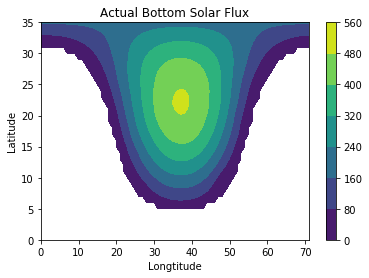

<Figure size 432x288 with 0 Axes>

In [30]:
plt.contourf(full_out_contour)
plt.colorbar()
plt.title("Actual Bottom Solar Flux")
plt.xlabel("Longtitude")
plt.ylabel("Latitude")
plt.show()
plt.savefig("Actual")

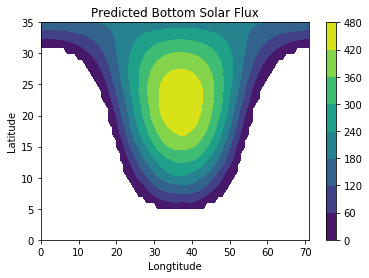

<Figure size 432x288 with 0 Axes>

In [31]:
plt.contourf(full_pred_contour)
plt.colorbar()
plt.title("Predicted Bottom Solar Flux")
plt.xlabel("Longtitude")
plt.ylabel("Latitude")
plt.show()
plt.savefig("Predicted")

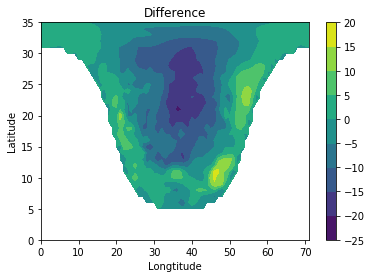

In [32]:
plt.contourf(full_pred_contour - full_out_contour)
plt.colorbar()
plt.title("Difference")
plt.xlabel("Longtitude")
plt.ylabel("Latitude")
plt.show()

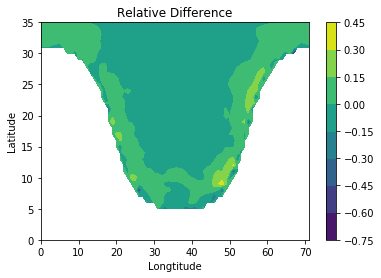

In [33]:
plt.contourf((full_pred_contour - full_out_contour)/full_out_contour)
plt.colorbar()
plt.title("Relative Difference")
plt.xlabel("Longtitude")
plt.ylabel("Latitude")
plt.show()

Predictor trying to just minimize MSE (not relative error):

In [34]:
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression

train_set, test_set = train_test_split(e_reml, test_size=0.2, random_state=42)

train_in = train_set.iloc[:,:106] #training input
train_out = train_set.iloc[:,106] #training output
test_in = test_set.iloc[:,:106] #testing input 
test_out = test_set.iloc[:,106] #testing output

ol = LinearRegression() #linear regression for large flux data
ol.fit(train_in,train_out) #old linear regressor for large fluxes, equal weights (so relative error should be worse)

LinearRegression(copy_X=True, fit_intercept=True, n_jobs=None, normalize=False)

In [35]:
train_set, test_set = train_test_split(e_rems, test_size=0.2, random_state=42)

train_in = train_set.iloc[:,:106] #training input
train_out = train_set.iloc[:,106] #training output
test_in = test_set.iloc[:,:106] #testing input
test_out = test_set.iloc[:,106] #testing output

os = LinearRegression() #linear regression for small flux data
os.fit(train_in,train_out) #old linear regressor for small fluxes

LinearRegression(copy_X=True, fit_intercept=True, n_jobs=None, normalize=False)

In [36]:
def oclp(in_data): #"old" custom linear predictor
    in_data = np.array(in_data)
    out_data = []
    for instance in in_data:
        if instance[105] > 20:
            out_data.append(float(ol.predict(instance[:106].reshape(1,-1)))) #uses large flux predictor 
        else:
            out_data.append(float(os.predict(instance[:106].reshape(1,-1)))) #uses small flux predictor
    return np.array(out_data)

In [37]:
total_in = e_d.iloc[:,:106] #total input
total_out = e_d.iloc[:,106] #total output

In [38]:
total_o_pred = oclp(total_in) #total predicted with "old" predictor
tore = np.array((total_o_pred - total_out)/total_out)#total old relative error

In [49]:
int_err(total_o_pred, total_out) #the integral of the error, much smaller than above

-58.96119778935099

In [39]:
from sklearn.metrics import mean_squared_error

lin_mse = mean_squared_error(total_out, total_o_pred)
lin_rmse = np.sqrt(lin_mse)
lin_rmse  #lower, as expected

2.4103579922276386

In [40]:
tore_contour = np.full((36, 72), np.nan)
for index in ti_indices:
    lat_point = index//72 - 36*5
    long_point = index%72 - 1*72
    tore_contour[lat_point][long_point] = tore[np.where(all_indices == index)]

In [41]:
len(ti_indices) #non nan values

1320

In [42]:
noo = 0 #number of outliers
for i in range(36):
    for j in range(72):
        if(tore_contour[i,j] < -1 or tore_contour[i,j] > 1):
            tore_contour[i,j] = np.nan
            noo += 1
noo #22/1320 is around 1.7%, pretty small

22

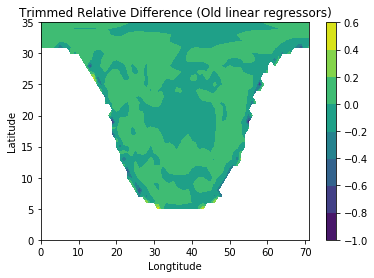

In [43]:
plt.contourf(tore_contour) #vmin = -1, vmax = 1) #levels=np.linspace(-1,1,50))
plt.colorbar()
plt.title("Trimmed Relative Difference (Old linear regressors)")
plt.xlabel("Longtitude")
plt.ylabel("Latitude")
plt.show()

Plotting which regressor handles which section:

In [44]:
def rh(in_data): #shows which regressor handles which data
    in_data = np.array(in_data)
    out_data = []
    for instance in in_data:
        if instance[105] > 20:
            out_data.append(1) #outputs 1 when large regressor is used
        else:
            out_data.append(0) #outputs 0 when small regressor is used
    return np.array(out_data)

In [45]:
lr = rh(total_in) #labelling which regressor handles which data points

lr_contour = np.full((36, 72), np.nan)
for index in ti_indices:
    lat_point = index//72 - 36*5
    long_point = index%72 - 1*72
    lr_contour[lat_point][long_point] = lr[np.where(all_indices == index)]

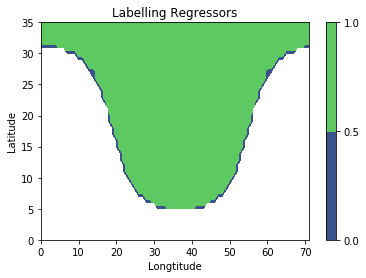

<Figure size 432x288 with 0 Axes>

In [46]:
plt.contourf(lr_contour, levels=[0,0.5,1])
plt.colorbar()
plt.title("Labelling Regressors")
plt.xlabel("Longtitude")
plt.ylabel("Latitude")
plt.show()
plt.savefig("Actual")